In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sets import Set
import calendar
import seaborn as sns
import csvWOD
import ctd_read
import copy
import seawater as SW
import os
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import scipy.io as sio

# switch to unbuffered output
# we create a class that overrides the write function of a stream object
# in this write function, we call the super write, then we also flush
# the stream -- this has the effect of forcing output to the screen after 
# every write
class Unbuffered(object):
    def __init__(self, stream):
        self.stream = stream
    def write(self, data):
        self.stream.write(data)
        self.stream.flush()
    def __getattr__(self, attr):
        return getattr(self.stream, attr)

import sys
sys.stdout = Unbuffered(sys.stdout)

sns.set()
sns.set_style("darkgrid")
sns.set_context("poster")

%matplotlib inline

In [37]:
def conv_ctd_dat_to_csvWOD(thedata,index,station,latitude,longitude,date_inf):
    ret_dat = {}
    
    ret_dat['Station'] = station
    ret_dat['Latitude'] = latitude
    ret_dat['Longitude'] = longitude
    ret_dat['Variables'] = []
    allkeys = {'Temperature' : 'Temperatur', 'Salinity' : 'Salinity' , 'Oxygen' : 'Oxygen', 'Fluorescence' : 'Fluorescence', 'Turbidity' : 'Turbidity'}
    for key,val in allkeys.iteritems():
        if key in index:
            ret_dat[val] = list(thedata[index[key]])
            ret_dat['Variables'].append(val)
    
    ret_dat['Year'] = date_inf['Year']
    ret_dat['Month'] = date_inf['Month']
    ret_dat['Units'] = ['degrees C','psu','g/kg','m']#,'','']
    
    
    # convert from pressure to depth
    p = thedata[index['Pressure']]
    d = []
    for ii in p:
        d.append(SW.dpth(ii,latitude))
    
    ret_dat['Depth'] = list(d)
    
    return ret_dat

def load_ctd_dat():
    #dir1 = '/ocean/rirwin/2_FALKOR_Data/7_Falkor_CTD/'
    #filenames = [dir1+f for f in os.listdir(dir1) if (f.startswith('2013-57-00') and f.endswith('avg'))]
    
    # ignore the falkor directory CTD data --- should be in IOS data anyways
    dir1 = '/ocean/rirwin/2_FALKOR_Data/6_IOS_Data/'
    filenames = [dir1+f for f in os.listdir(dir1) if (f.endswith('ctd'))]

    all_casts = []
    for count,filename in enumerate(sorted(filenames)):
        thedata,index,station,lat,lon,dateinf = ctd_read.ctd_read(filename) #ctd_read.ctd_read(filename)
         
        #print [('[',k,']') for k in lat.split(' ')]
        if len(lat.split(' ')[3]) > 0:
            latitude = float(lat.split(' ')[1]) + float(lat.split(' ')[3])/60.0
        else:
            latitude = float(lat.split(' ')[1]) + float(lat.split(' ')[4])/60.0
        
        #print [('[',k,']') for k in lon.split(' ')]
        if len(lon.split(' ')[2]) > 0:
            longitude = -(float(lon.split(' ')[0]) + float(lon.split(' ')[2])/60.0)
        else:
            longitude = -(float(lon.split(' ')[0]) + float(lon.split(' ')[3])/60.0)
        
        all_casts.append(conv_ctd_dat_to_csvWOD(thedata,index,station,latitude,longitude,dateinf))
        
    return all_casts
    
def load_NOAA_dat():
    cast_inf = []

    FILES = ['../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv',
             #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv',
             #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv',
             #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD4.csv',
             #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD5.csv'
             #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.OSD.csv'
            ]

    for fn in FILES:
        print '-----------------------------------------------------------------'
        print fn
        print '-----------------------------------------------------------------'
        print '> Parsing'
        tmp_casts = []
        tmp_casts = csvWOD.read_casts(fn)
        print '> Done parsing'
        print '> Regionally filtering' # likely don't need this filter 
        #tmp_casts = csvWOD.filter_region(tmp_casts,-160,-120,15,60)
        tmp_casts = csvWOD.filter_variables(tmp_casts,['Temperatur','Salinity','Depth'])
        print '> Done filtering'
        print '> Appending new casts'
        cast_inf.extend(tmp_casts)
        print '> Done' 
        print ''

    print 'Total casts: ', len(cast_inf)
    return cast_inf

def load_all_data():
    print '========================================='
    print ''
    print '            LOADING FALKOR DATA'
    print ''
    print '========================================='
    
    FALKOR_CAST = load_ctd_dat()
    
    print '========================================='
    print ''
    print '            LOADING NOAA DATA'
    print ''
    print '========================================='
    
    NOAA_CAST = []#load_NOAA_dat()
        
    print 'DONE'
    NOAA_CAST.extend(FALKOR_CAST)
    
    return NOAA_CAST

In [38]:
cast_inf = csvWOD.filter_variables(load_all_data(),['Temperatur','Salinity'])


            LOADING FALKOR DATA

> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-05-0008.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-05-0011.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-14-0008.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-14-0010.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-14-0013.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-14-0014.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2002-16-0002.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0047.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0048.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0049.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0050.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0051.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0052.ctd
> reading  /ocean/rirwin/2_FALKOR_Data/6_IOS_Data/2006-14-0053.ctd
> reading  /ocean/rirwin/2_F

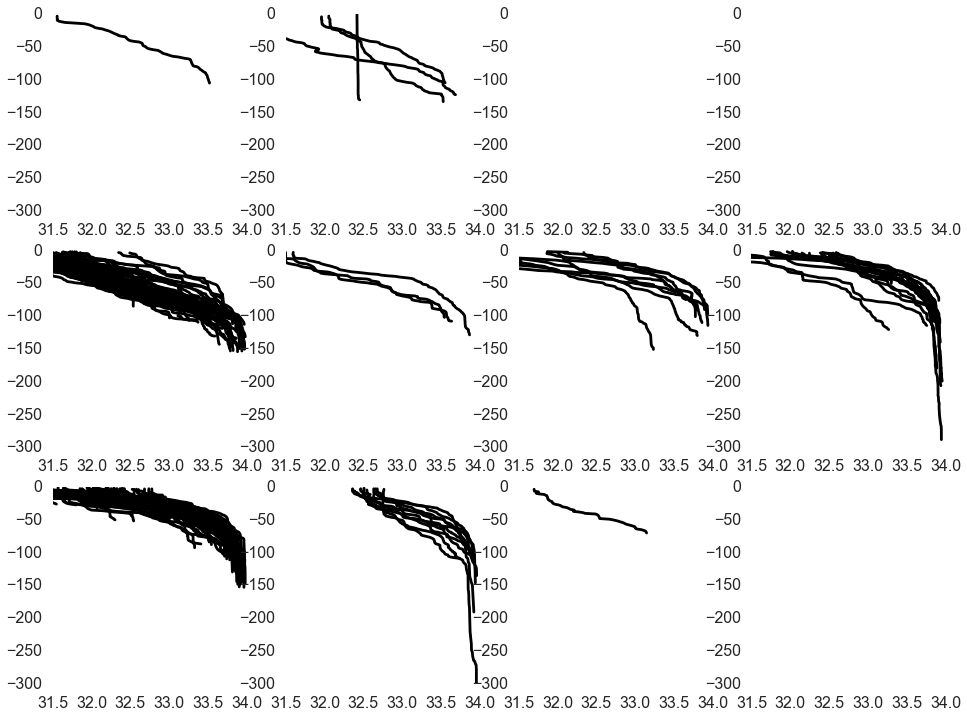

In [45]:
plt.figure(figsize=(16,12))
for ii in range(1,13):
    plt.subplot(3,4,ii)
    mnth_inf = csvWOD.filter_month(cast_inf,ii)
    
    for ii in mnth_inf:
        plt.plot(ii['Salinity'],-np.array(ii['Depth']),'-k',ms=2)
        
    plt.xlim((31.5,34))
    plt.ylim((-300,0))

plt.show()